# Extração dos dados de TEC para as estações escolhidas
___

Os dados da série temporal para o TEC consiste de uma matriz para cada instante de tempo. Dado uma latitude e longitude é possível mapear para um par $(i, j)$ correspondendo a uma entrada da matriz. O papel deste notebook é varrer a série e extrair os dados de apenas algumas estações, isto é, dada a sua localização, é possível extrair da matriz um valor de tec. A coleção de valores extraídos ao longo do tempo, para uma dada estação, gera uma série temporal para esta.

Além da extração dos dados, uma suavização é aplicado as séries temporais encontradas.

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.signal import savgol_filter

import utils

from utils import local_data
from utils import window

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# load dataframe of stations
# load series of tec data
# load series of tec data first order derivative
# load series of tec data second order derivative

files = ['data_series_tec.pkl.xz', 'data_series_tec_first_derivative.pkl.xz', 'data_series_tec_second_derivative.pkl.xz']
df_station = pd.read_pickle(os.path.join(local_data, 'df_station_sort.pkl'))

In [3]:
df_station

,identificationstation,height,latitude,longitude,state,city
city_name_correct,,,,,,
Alta Floresta,afl,267.000,-9.870000,-55.900000,mt,alta floresta
Belo Horizonte,bhz,858.000,-19.868500,-47.869400,mg,belo horizonte
Boa Vista,bov,69.180,2.833920,-60.695380,rr,boa vista
Brasília,bsa,1050.000,-15.764200,-47.869400,df,brasilia
Cachoeira Paulista,cpa,580.000,-22.410000,-45.000000,sp,cachoeira paulista
Campo Grande,32,NaN,-20.497000,-54.615000,ms,campos grande
Cuiaba,cub,278.000,-15.555200,-56.069800,mt,cuiaba
Dourados,dou,756.120,-22.110000,-54.550000,ms,dourados
Fortaleza,24,NaN,-3.742000,-38.539000,ce,fortaleza


In [4]:
def extract_series_station_from_array(df, list_of_stations, window):
    data = utils.extract_vtec(df)
    # generate panda dataframe of timestamps, where there are tec information
    df_series = pd.DataFrame(index=utils.extract_index(df))
    
    for row in list_of_stations:
        i, j = utils.ij_par(row.longitude, row.latitude)
        series = [float(vtec_matrix[i][j]) for vtec_matrix in data]
        series_filter = savgol_filter(np.array(series), window, 3)
        df_series[row.identificationstation] = series_filter
    
    return df_series

In [5]:
abs_path = os.path.join(local_data, files[0])
df_series = extract_series_station_from_array(pd.read_pickle(abs_path), 
                                              df_station.itertuples(), 
                                              window)

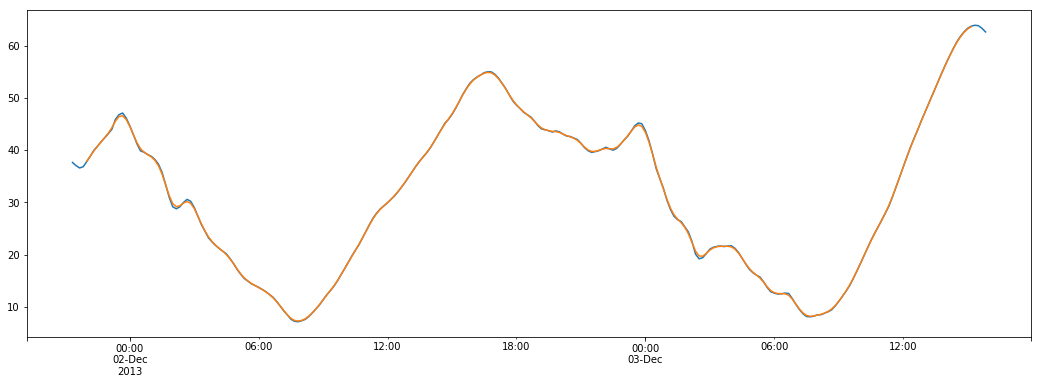

In [6]:
# just for visualization
ax = df_series['sj2'][128:384].plot(figsize=(18, 6))
df_series['sj2'][128:384].rolling(window, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(18, 6), ax=ax);

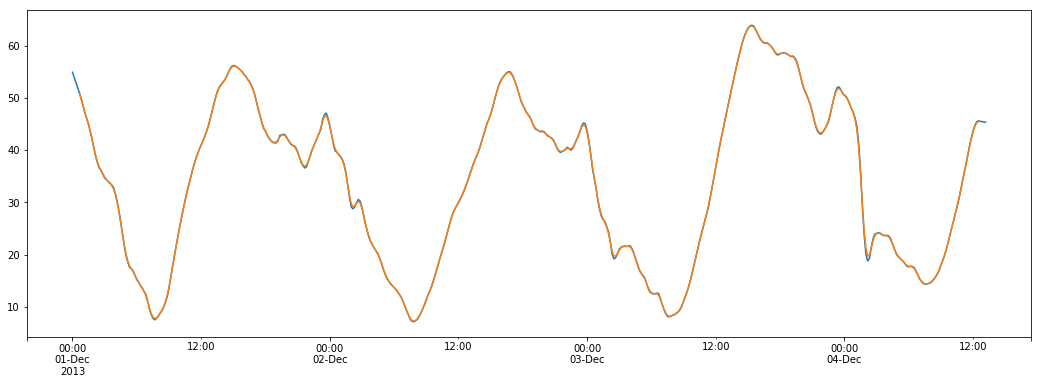

In [7]:
# just for visualization
ax = df_series['sj2'][0:512].plot(figsize=(18, 6))
df_series['sj2'][0:512].rolling(window, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(18, 6), ax=ax);

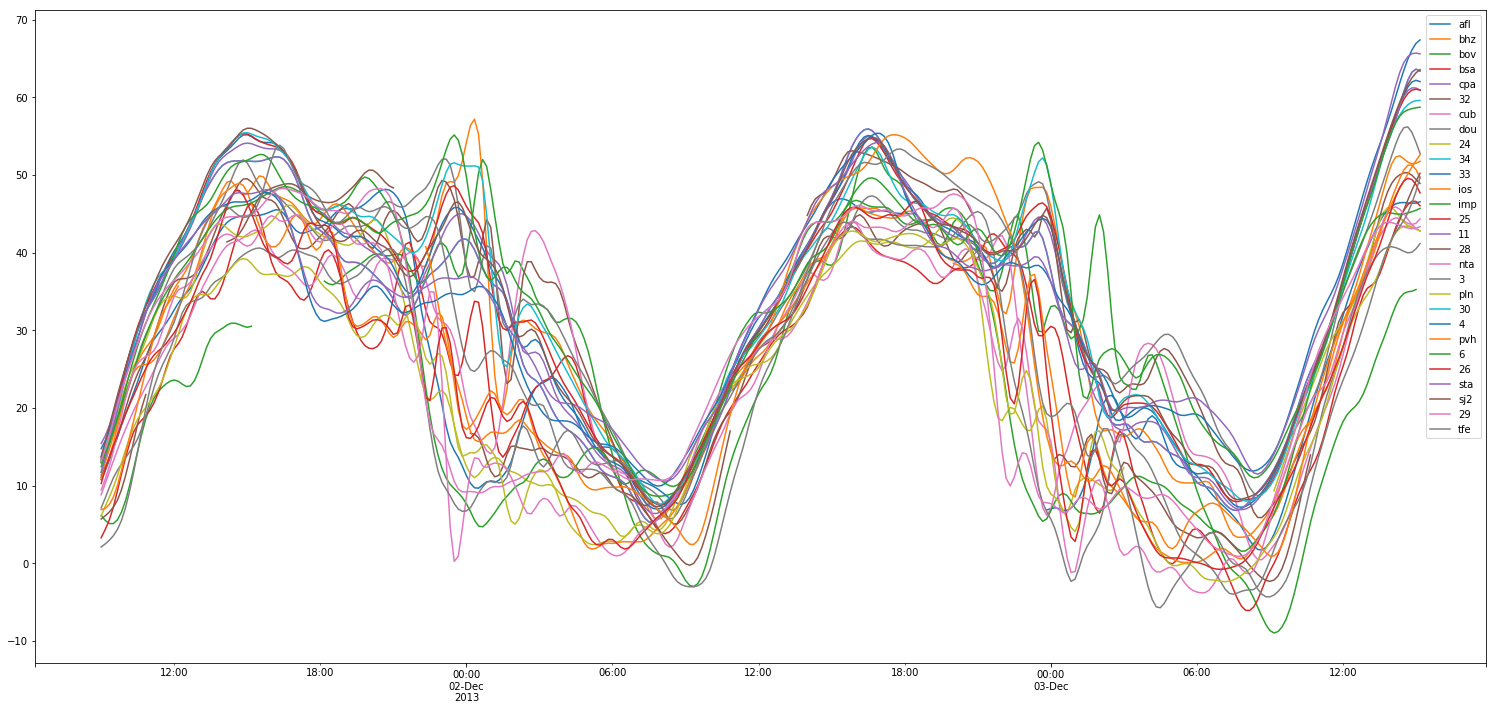

In [8]:
# just for visualization
df_series[50:384].rolling(window, win_type='gaussian', center=True).mean(std=1.0).plot(figsize=(26, 12));

In [9]:
for file in files:
    abs_path = os.path.join(local_data, file)
    df_series = extract_series_station_from_array(pd.read_pickle(abs_path), 
                                                  df_station.itertuples(), window)
    rolling = df_series.rolling(window, win_type='gaussian', center=True)
    df_series = rolling.mean(std=1.0)
    df_series.to_pickle(os.path.join(local_data, 'station_' + file), compression='xz')